# Part 4: CatBoost Model Comparison (Outlier vs No Outlier)

### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 

from catboost import CatBoostClassifier

from sklearn.metrics import f1_score,accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score, confusion_matrix
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
C:\Users\sumai\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Load Dataset
Please see the link to know more about the dataset: https://www.kaggle.com/jboysen/mri-and-alzheimers

In [2]:
df = pd.read_csv('preprocessed_oasis_longitudinal.csv')
df = df. drop('Unnamed: 0', axis=1)
df.head()

,Visit,Gender,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,1,2,87,14,2.0,27.0,0,1987,0.696,0.883
1,2,2,88,14,2.0,30.0,0,2004,0.681,0.876
2,1,2,75,12,0.0,23.0,1,1678,0.736,1.046
3,2,2,76,12,0.0,28.0,1,1738,0.713,1.010
4,3,2,80,12,0.0,22.0,1,1698,0.701,1.034


## Handling Outliers

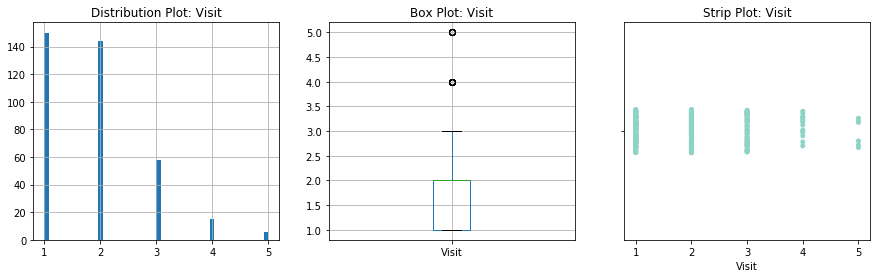

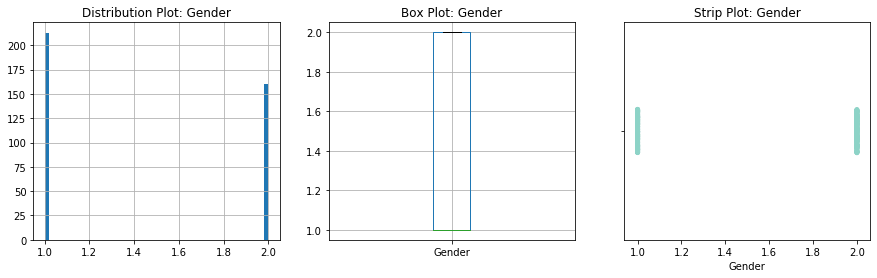

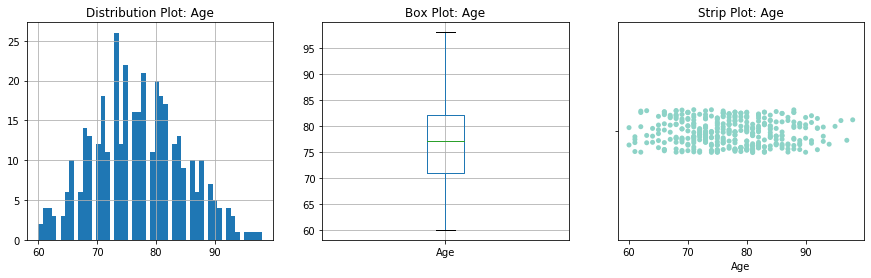

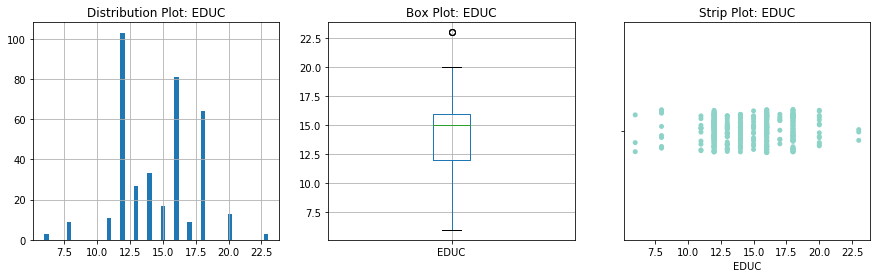

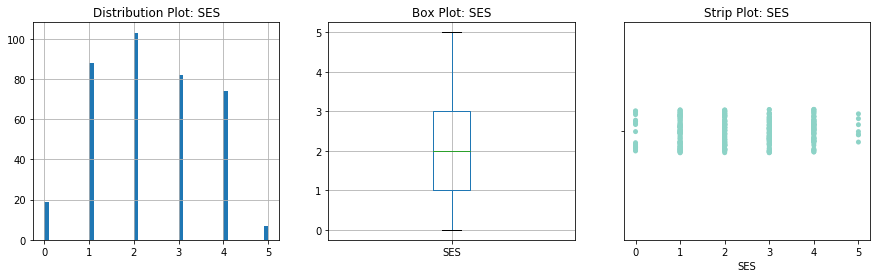

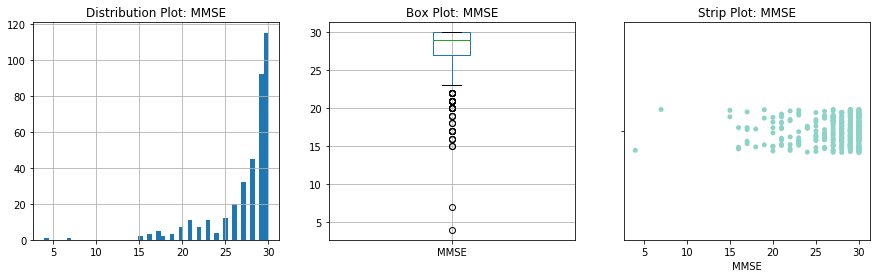

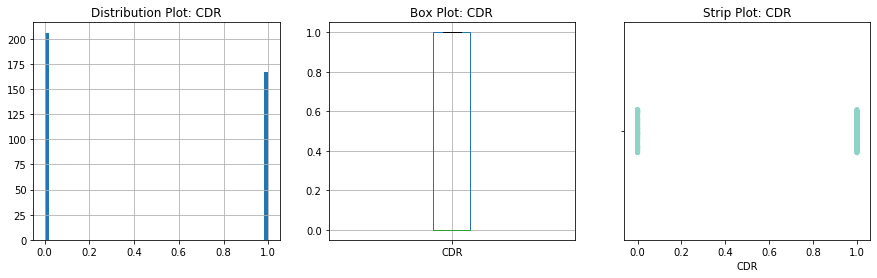

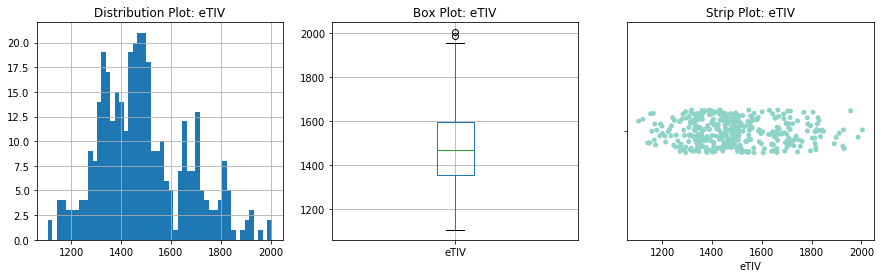

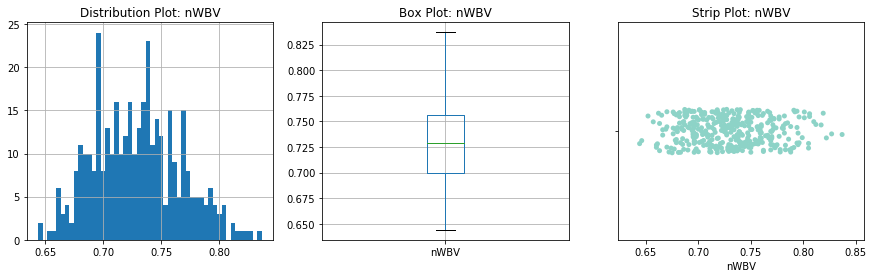

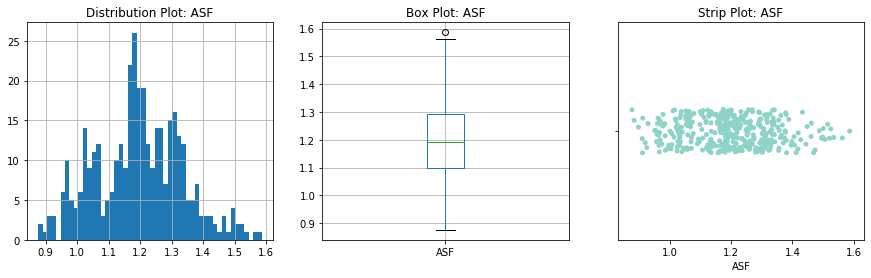

In [3]:
data = df.copy()
cols = data.columns.to_list()

for col in cols:
        
    plt.figure(figsize=(15, 4))
    plt.subplot(1,3,1)
    data[col].hist(bins = 50)
    plt.title('Distribution Plot: {}'.format(col))

    plt.subplot(1,3,2)
    data.boxplot(column = col)
    plt.title('Box Plot: {}'.format(col))

    plt.subplot(1,3,3)
    sns.stripplot(x=data[col], palette='Set3')
    plt.title('Strip Plot: {}'.format(col))
    plt.show()

In [4]:
skewed = ['MMSE']
not_skewed  = ['eTIV', 'ASF']

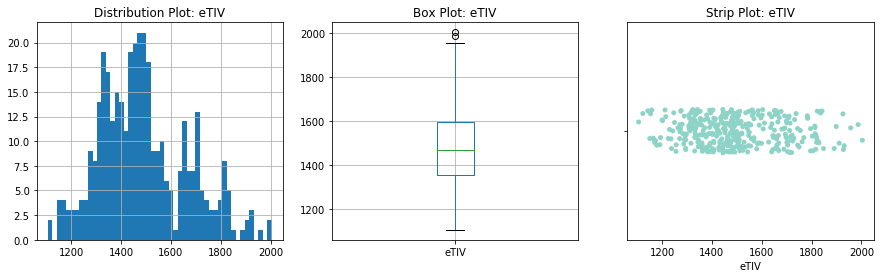

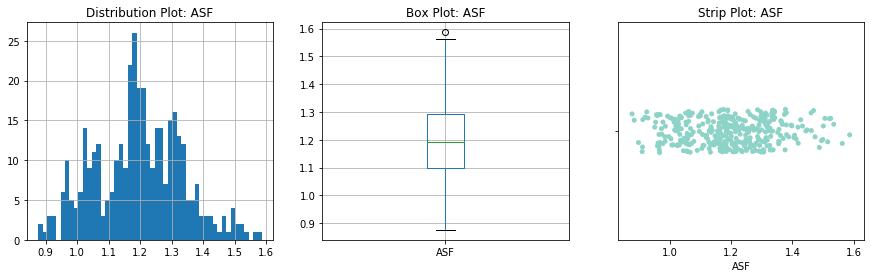

In [5]:
for col in not_skewed: 
    
    uppper_boundary = data[col].mean() + 3* data[col].std()
    lower_boundary = data[col].mean() - 3* data[col].std()

    data.loc[data[col] >= uppper_boundary, col] = uppper_boundary

    plt.figure(figsize=(15, 4))
    plt.subplot(1,3,1)
    data[col].hist(bins = 50)
    plt.title('Distribution Plot: {}'.format(col))

    plt.subplot(1,3,2)
    data.boxplot(column = col)
    plt.title('Box Plot: {}'.format(col))

    plt.subplot(1,3,3)
    sns.stripplot(x=data[col], palette='Set3')
    plt.title('Strip Plot: {}'.format(col))
    plt.show()

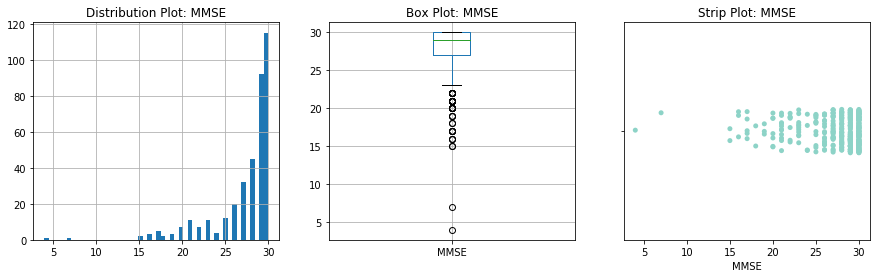

In [6]:
for col in skewed:  
        
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)

    lower_bridge = data[col].quantile(0.25) - (IQR*1.5)
    upper_bridge = data[col].quantile(0.75) + (IQR*1.5)

    data.loc[data[col]>= upper_bridge, col] = upper_bridge

    plt.figure(figsize=(15, 4))
    plt.subplot(1,3,1)
    data[col].hist(bins = 50)
    plt.title('Distribution Plot: {}'.format(col))

    plt.subplot(1,3,2)
    data.boxplot(column = col)
    plt.title('Box Plot: {}'.format(col))

    plt.subplot(1,3,3)
    sns.stripplot(x=data[col], palette='Set3')
    plt.title('Strip Plot: {}'.format(col))
    plt.show()

### Split Input and Traget Variables

In [7]:
X = df.drop('CDR', axis = 1) 
y = df['CDR']

X_data = data.drop('CDR', axis = 1) 
y_data = data['CDR']

### Train Test Split

In [8]:
# train_test_split is used to split the dataset into test set and train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.26, random_state =0)
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X_data, y_data, test_size=0.26, random_state =0)

print("Original shape of dataset: {}".format(df.shape))         # shape of original dataset
print("Shape of training dataset: {}".format(X_train.shape))      # shape of training dataset after split
print("Shape of testing dataset: {}".format(X_test.shape))        # shape of testing dataset after split

Original shape of dataset: (373, 10)
Shape of training dataset: (276, 9)
Shape of testing dataset: (97, 9)


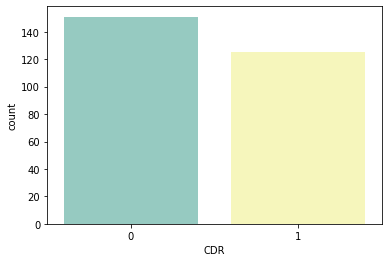

In [9]:
sns.countplot(y_train, palette='Set3')

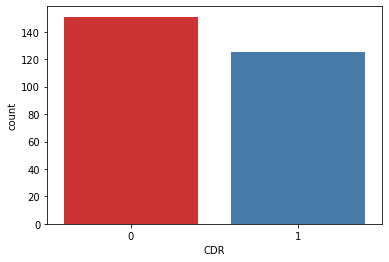

In [10]:
sns.countplot(y_train_data, palette='Set1')

## Feature Scaling

In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train_data = sc.fit_transform(X_train_data)
X_test_data = sc.transform(X_test_data)

## Final Model (with outliers)

In [12]:
model = CatBoostClassifier(logging_level='Silent', random_state = 42)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
y_hat_train = model.predict(X_train)

rec = recall_score(y_test, y_hat)
print ("Recall Score:", round(rec, 4))

rec_mac = recall_score(y_test, y_hat, average = 'macro')
print ("Macro Average of Recall Score:", round(rec_mac, 4))

rec_wei = recall_score(y_test, y_hat, average = 'weighted')
print ("Weighted Average of Recall Score:", round(rec_wei, 4))

print ('------------------------------------------------------')

prec_mac = precision_score(y_test, y_hat, average = 'macro')
print ("Macro Average of Precision Score:", round(prec_mac, 4))

prec_wei = precision_score(y_test, y_hat, average = 'weighted')
print ("Weighted Average of Precision Score:", round(prec_wei, 4))

print ('------------------------------------------------------')

f1_mac = f1_score(y_test, y_hat, average = 'macro')
print ("Macro Average of F1 Score:", round(f1_mac, 4))

f1_wei = f1_score(y_test, y_hat, average = 'weighted')
print ("Weighted Average of F1 Score:", round(f1_wei, 4))

print('.')

acc = accuracy_score(y_test, y_hat)
print ("Accuracy Score:", round(acc, 4))

Recall Score: 0.8333
Macro Average of Recall Score: 0.8712
Weighted Average of Recall Score: 0.8763
------------------------------------------------------
Macro Average of Precision Score: 0.8761
Weighted Average of Precision Score: 0.8762
------------------------------------------------------
Macro Average of F1 Score: 0.8733
Weighted Average of F1 Score: 0.8759
.
Accuracy Score: 0.8763


In [13]:
acc_train = metrics.accuracy_score(y_train, y_hat_train)
print ("Accuracy Score of Train Set:", acc_train)
    
acc_test = metrics.accuracy_score(y_test, y_hat)
print ("Accuracy Score of Test Set:", acc_test)
    
print ('.')
    
f1_train = metrics.f1_score(y_train, y_hat_train, average = 'macro')
print ("F1 Score of Train Set:", f1_train)
    
f1_test = metrics.f1_score(y_test, y_hat, average = 'macro')
print ("F1 Score of Test Set:", f1_test)

Accuracy Score of Train Set: 0.9963768115942029
Accuracy Score of Test Set: 0.8762886597938144
.
F1 Score of Train Set: 0.9963418028549843
F1 Score of Test Set: 0.8732578397212543


## Final Model (without outliers)

In [14]:
model = CatBoostClassifier(logging_level='Silent', random_state = 42)
model.fit(X_train_data, y_train_data)
y_hat_data = model.predict(X_test_data)
y_hat_train_data = model.predict(X_train_data)

rec = recall_score(y_test_data, y_hat_data)
print ("Recall Score:", round(rec, 4))

rec_mac = recall_score(y_test_data, y_hat_data, average = 'macro')
print ("Macro Average of Recall Score:", round(rec_mac, 4))

rec_wei = recall_score(y_test_data, y_hat_data, average = 'weighted')
print ("Weighted Average of Recall Score:", round(rec_wei, 4))

print ('------------------------------------------------------')

prec_mac = precision_score(y_test_data, y_hat_data, average = 'macro')
print ("Macro Average of Precision Score:", round(prec_mac, 4))

prec_wei = precision_score(y_test_data, y_hat_data, average = 'weighted')
print ("Weighted Average of Precision Score:", round(prec_wei, 4))

print ('------------------------------------------------------')

f1_mac = f1_score(y_test_data, y_hat_data, average = 'macro')
print ("Macro Average of F1 Score:", round(f1_mac, 4))

f1_wei = f1_score(y_test_data, y_hat_data, average = 'weighted')
print ("Weighted Average of F1 Score:", round(f1_wei, 4))

print('.')

acc = accuracy_score(y_test_data, y_hat_data)
print ("Accuracy Score:", round(acc, 4))

Recall Score: 0.8333
Macro Average of Recall Score: 0.8712
Weighted Average of Recall Score: 0.8763
------------------------------------------------------
Macro Average of Precision Score: 0.8761
Weighted Average of Precision Score: 0.8762
------------------------------------------------------
Macro Average of F1 Score: 0.8733
Weighted Average of F1 Score: 0.8759
.
Accuracy Score: 0.8763


In [15]:
acc_train_data = metrics.accuracy_score(y_train_data, y_hat_train_data)
print ("Accuracy Score of Train Set:", acc_train_data)
    
acc_test_data = metrics.accuracy_score(y_test_data, y_hat_data)
print ("Accuracy Score of Test Set:", acc_test_data)
    
print ('.')
    
f1_train_data = metrics.f1_score(y_train_data, y_hat_train_data, average = 'macro')
print ("F1 Score of Train Set:", f1_train_data)
    
f1_test_data = metrics.f1_score(y_test_data, y_hat_data, average = 'macro')
print ("F1 Score of Test Set:", f1_test_data)

Accuracy Score of Train Set: 0.9963768115942029
Accuracy Score of Test Set: 0.8762886597938144
.
F1 Score of Train Set: 0.9963418028549843
F1 Score of Test Set: 0.8732578397212543


## Conclusion

### We will keep the features unchanged.